<a href="https://colab.research.google.com/github/saigontrade88/AML-XAI-Project/blob/master/CW_CIFAR10_Attack_l2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
import MNIST_Model
import numpy as np


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 281MB/s]


## Model & dataset

In [5]:
target_model=MNIST_Model.MNIST_Model().cuda()
target_model.load_state_dict(torch.load("mnist.pt"))
target_model.eval()
test_data=datasets.MNIST(root='./mnist/', train=False, download=True,transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 400081903.47it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38443571.51it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 186371979.00it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4724833.52it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## Inital Input data

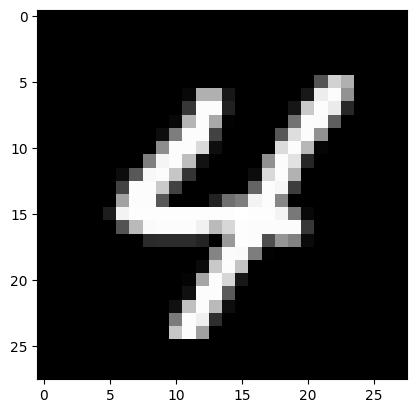

The pred result is  4


In [6]:
target_model.eval()
test_img,test_label=test_data[8222]
img = transforms.ToPILImage()(test_img).convert('RGB')
plt.imshow(img)
plt.show()
inputimg=Variable(torch.unsqueeze(test_img, 0)).cuda()
output = target_model(inputimg)
print("The pred result is ",output.argmax(1, keepdim=True).item())

## CK Attack based on l2 attack

In [7]:
def loss1_func(w,x,d,c):
    return torch.dist(x,(torch.tanh(w)*d+c),p=2)

def f(output,tlab,target,k=0):
    #f函数选用作者觉得最好的f6 f6(x)=max((max(Z(x')i)-Z(x')t),-k)
    real= torch.max(output*tlab)
    second=torch.max((1-tlab)*output)
    #如果指定了对象，则让这个更接近，否则选择第二个较大的
    if(target):
        return torch.max(second - real, torch.Tensor([-k]).cuda())
    else:
        return torch.max(real - second, torch.Tensor([-k]).cuda())

def cwattack_l2(img,model,right_label,iteration=1000,lr=0.001,target=False,target_label=0):
    shape=(1,3,28,28)
    binary_number=9                         #二分搜索
    maxc=1e10                               #从0.01-100去找c
    minc=0
    c=1e-3                                   #from c = 0:01 to c = 100 on the MNIST dataset.
    min_loss=1000000                         #找到最小的loss，即为方程的解
    min_loss_img=img                         #扰动后的图片
    k=0                                      #f函数使用，论文默认为0
    b_min = 0                                #盒约束，论文中使用了0-1 代码中-0.5 0.5
    b_max = 1
    b_mul=(b_max-b_min)/2.0
    b_plus=(b_min+b_max)/2.0
    if(not target):
        target_label=right_label
    tlab=Variable(torch.from_numpy(np.eye(10)[target_label]).cuda().float())
    for binary_index in range(binary_number):
        print("------------Start {} search, current c is {}------------".format(binary_index,c))

        #将img转换为w，w=arctanh(2x-1)，作为原始图片
        w = Variable(torch.from_numpy(np.arctanh((img.numpy()-b_plus)/b_mul*0.99999)).float()).cuda()

        w_pert=Variable(torch.zeros_like(w).cuda().float())
        w_pert.requires_grad = True
        #最初图像x
        x= Variable(img).cuda()
        optimizer = optim.Adam([w_pert], lr=lr) #论文p3选用Adam
        isSuccessfulAttack=False

        for iteration_index in range(1,iteration+1):
            optimizer.zero_grad()

            # w加入扰动w_pert之后的新图像
            img_new=torch.tanh(w_pert+w)*b_mul+b_plus  #0.5*tanh(w+pert)+0.5
            loss_1=loss1_func(w,img_new,b_mul,b_plus)  #\\ deta\\  p=2
            model.eval()
            output=model(img_new)                      # Z(x)
            loss_2=c*f(output,tlab,target)             # c*f(x+deta) , x+deta=img_new,
            loss=loss_1+loss_2                         # Minimize loss=loss1+loss2
            loss.backward(retain_graph=True)
            optimizer.step()
            if iteration_index%200==0:
                 print('Iters: [{}/{}]\tLoss: {},Loss1(L2 distance):{}, Loss2:{}'
                       .format(iteration_index,iteration,loss.item(),loss_1.item(),loss_2.item()))

            pred_result=output.argmax(1, keepdim=True).item()
            #指定目标模式下,此处考虑l2距离最小,即找到最小的loss1
            if(target):
                if(min_loss>loss_1 and pred_result==target_label):
                    flag=False
                    for i in range(20):
                        output=model(img_new)
                        pred_result=output.argmax(1, keepdim=True).item()
                        if(pred_result!=target_label):
                            flag=True  #原模型中存在dropout，此处判断连续成功攻击20次，则视为有效
                            break
                    if(flag):
                        continue
                    min_loss=loss_1
                    min_loss_img=img_new
                    print('success when loss: {}, pred: {}'.format(min_loss,pred_result))
                    isSuccessfulAttack=True
             #非目标模式，找到最接近的一个,连续20次不预测成功
            else:
                if(min_loss>loss_1 and pred_result!=right_label):
                    flag=False
                    for i in range(50):
                        output=model(img_new)
                        pred_result=output.argmax(1, keepdim=True).item()
                        if(pred_result==right_label):
                            flag=True  #原模型中存在dropout，此处判断连续成功攻击50次，则视为有效
                            break
                    if(flag):
                        continue
                    min_loss=loss_1
                    min_loss_img=img_new
                    print('success when loss: {}, pred: {}'.format(min_loss,pred_result))
                    isSuccessfulAttack=True
        if(isSuccessfulAttack):
            maxc=min(maxc,c)
            if maxc<1e9:
                c=(minc+maxc)/2
        #攻击失败，尝试放大c
        else:
            minc=max(minc,c)
            if(maxc<1e9):
                c=(maxc+minc)/2
            else:
                c=c*10
    return min_loss_img


## Target Attack (Target label = 3)

In [8]:
victim_img=test_img
victim_label=test_label
print("Correct Label is ",victim_label)
victim_img_input = torch.unsqueeze(victim_img, 0)
attack_img = cwattack_l2(victim_img_input,target_model,victim_label,
                         iteration=1000,lr=0.01,target=True,target_label=3)

Correct Label is  4
------------Start 0 search, current c is 0.001------------
Iters: [200/1000]	Loss: 0.08801810443401337,Loss1(L2 distance):0.0016381205059587955, Loss2:0.08637998253107071
Iters: [400/1000]	Loss: 0.07928796112537384,Loss1(L2 distance):0.0022124494425952435, Loss2:0.07707551121711731
Iters: [600/1000]	Loss: 0.09063728153705597,Loss1(L2 distance):0.0013625134015455842, Loss2:0.08927477151155472
Iters: [800/1000]	Loss: 0.08891872316598892,Loss1(L2 distance):0.0014488623710349202, Loss2:0.08746986091136932
Iters: [1000/1000]	Loss: 0.10272736102342606,Loss1(L2 distance):0.0013206973671913147, Loss2:0.10140666365623474
------------Start 1 search, current c is 0.01------------
Iters: [200/1000]	Loss: 1.3416922092437744,Loss1(L2 distance):0.0013896457385271788, Loss2:1.340302586555481
Iters: [400/1000]	Loss: 0.8143824934959412,Loss1(L2 distance):0.0015862415311858058, Loss2:0.8127962350845337
Iters: [600/1000]	Loss: 1.0268924236297607,Loss1(L2 distance):0.0014208881184458733

## Attack Visualization

In [9]:
from tqdm import tqdm
def show3(ori,adv):
    plt.figure()
    plt.subplot(131)
    plt.title('Input Image')
    img1 = transforms.ToPILImage()(ori).convert('RGB')
    plt.imshow(img1)
    plt.subplot(132)
    plt.title('Adversarial Image')
    img2 =torch.tensor(adv).cpu()
    img2=torchvision.utils.make_grid(img2, normalize=True)
    Pert=img2-ori
    img2 = transforms.ToPILImage()(img2).convert('RGB')
    Pert = transforms.ToPILImage()(Pert).convert('RGB')
    plt.imshow(img2)
    plt.subplot(133)
    plt.title('Perturbation')
    plt.imshow(Pert)
    plt.show()


<ipython-input-9-0654f5ace7fd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2 =torch.tensor(adv).cpu()


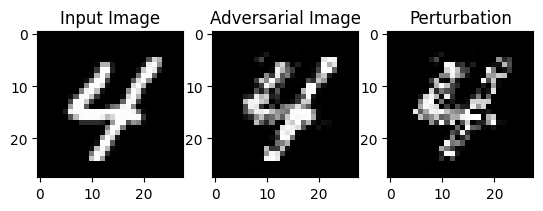

In [10]:
show3(victim_img,attack_img)

In [11]:
target_model.eval()
output = target_model(attack_img)
print("The pred result is ",output.argmax(1, keepdim=True).item())

The pred result is  3


### Repeat 30 times (93.33% that the target model will predict the adversarial instance as 3!!!)

In [12]:
sum_accuracy=0

for i in tqdm(range(30)):
    output = target_model(attack_img)
    if(output.argmax(1, keepdim=True).item()==3):
        sum_accuracy+=1
print("accuracy :",sum_accuracy*1.0/30)

100%|██████████| 30/30 [00:00<00:00, 1072.10it/s]

accuracy : 0.9333333333333333


## Untarget Attack

In [13]:
victim_img2,victim_label2=test_data[5652]
print("Correct Label is ",victim_label2)

victim_img_input2 = torch.unsqueeze(victim_img2, 0)
attack_untarget_img = cwattack_l2(victim_img_input2,target_model,victim_label2,
                         iteration=1000,lr=0.01)

Correct Label is  0
------------Start 0 search, current c is 0.001------------
Iters: [200/1000]	Loss: 0.029667051509022713,Loss1(L2 distance):0.0015749933663755655, Loss2:0.02809205837547779
Iters: [400/1000]	Loss: 0.03645845502614975,Loss1(L2 distance):0.0015353546477854252, Loss2:0.03492309898138046
Iters: [600/1000]	Loss: 0.04419839009642601,Loss1(L2 distance):0.001767539419233799, Loss2:0.042430851608514786
Iters: [800/1000]	Loss: 0.032690778374671936,Loss1(L2 distance):0.0012530522653833032, Loss2:0.03143772482872009
Iters: [1000/1000]	Loss: 0.02773362398147583,Loss1(L2 distance):0.001126161776483059, Loss2:0.026607463136315346
------------Start 1 search, current c is 0.01------------
Iters: [200/1000]	Loss: 0.3451516032218933,Loss1(L2 distance):0.0014725941000506282, Loss2:0.3436790108680725
Iters: [400/1000]	Loss: 0.35310912132263184,Loss1(L2 distance):0.0013357995776459575, Loss2:0.35177332162857056
Iters: [600/1000]	Loss: 0.3954460620880127,Loss1(L2 distance):0.00145427777897

### 无目标的随机攻击准确率相对较低（87%）可能来自于几个方面：
#### 1. 有目标攻击时，模型将集中收敛在一个特定区域，无目标攻击当识别结果不准确即判定成功，存在一定误差
#### 2. MNIST模型使用了dropout层，增强了原模型的鲁棒性
#### 3. MNIST数据集使用的是28 * 28像素图片，数据量较小，换为物体识别例如ImageNet会更好
#### 4. 测试训练环境为GTX 1650S，可以考虑提高迭代次数，降低学习率，提高判断成功的连续攻击次数

### Untargeted random attacks The relatively low accuracy rate (87%) may come from several sources:
#### 1. When there is a target attack, the model will converge in a specific area. If there is no target attack, the recognition result is inaccurate, and the judgment is successful, there is a certain error
#### 2. The MNIST model uses the dropout layer, which enhances the robustness of the original model
#### 3. The MNIST data set uses 28*28 pixel pictures, the amount of data is small, and it will be better to replace it with ImageNet and other object recognition effects
#### 4. The test and training environment is GTX 1650S, you can consider increasing the number of iterations, reducing the learning rate, and increasing the number of consecutive attacks to judge success

<ipython-input-9-0654f5ace7fd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2 =torch.tensor(adv).cpu()


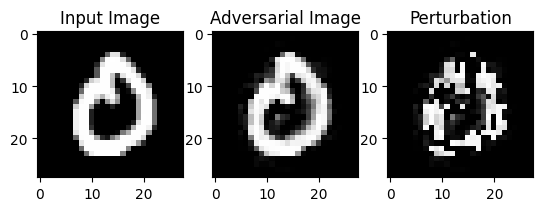

In [14]:
show3(victim_img2,attack_untarget_img)

In [15]:
target_model.eval()
output = target_model(attack_untarget_img)
print("The pred result is ",output.argmax(1, keepdim=True).item())

The pred result is  2


### Repeat 30 times (93.33% that the target model will predict the adversarial instance as a class which is not the '0' class!!!)

In [16]:
sum_accuracy=0

for i in tqdm(range(30)):
    output = target_model(attack_untarget_img)
    if(output.argmax(1, keepdim=True).item()!=0):
        sum_accuracy+=1
print("accuracy :",sum_accuracy*1.0/30)


100%|██████████| 30/30 [00:00<00:00, 879.15it/s]

accuracy : 0.9333333333333333
